### Resources Used

* Dataset
 - https://docs.rapids.ai/datasets/mortgage-data
 - https://capmrkt.fanniemae.com/portal/funding-the-market/data/loan-performance-data.html
* RAPIDS + Dask Documentation
 - https://docs.rapids.ai/api/cudf/stable/10min.html
 - https://docs.dask.org/en/latest/dataframe-best-practices.html
 - https://docs.dask.org/en/latest/setup/single-distributed.html#localcluster
 - https://distributed.dask.org/en/latest/memory.html
 - https://dask-cuda.readthedocs.io/en/latest/specializations.html
* Other examples with this dataset
 - https://www.dataquest.io/blog/data-science-portfolio-machine-learning/
 - https://github.com/dhananjaymehta/FannieMae_LoanForeclosure
 - https://degravek.github.io/project-pages/project1/2016/11/12/New-Notebook/
 - https://riskspan.com/hands-on-machine-learning-predicting-loan-delinquency/
 
 
 






## Create conda enviornment with the following libraries
```
conda create -n rapids-0.17 -c rapidsai -c nvidia -c conda-forge -c defaults rapids-blazing=0.17 python=3.7 cudatoolkit=11.0 matplotlib=3.3.3 gcsfs=0.7.1
```


## Check Environment

In [1]:
%%bash
nvidia-smi
nvcc --version

Thu Jan  7 06:58:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      On   | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    61W / 400W |      0MiB / 40537MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  A100-SXM4-40GB      On   | 00000000:00:05.0 Off |                    0 |
| N/A   

In [2]:
import numpy as np; print('numpy Version:', np.__version__)
import pandas as pd; print('pandas Version:', pd.__version__)
import xgboost as xgb; print('XGBoost Version:', xgb.__version__)
import cudf; print('cudf Version:', cudf.__version__)
import cuml; print('cudf Version:', cuml.__version__)
import gcsfs; print('gcsfs Version:', gcsfs.__version__)
import time
import dask_cudf; print('dask_cudf Version:', gcsfs.__version__)
import dask; print('dask Version:', gcsfs.__version__)
import dask.dataframe as dask_df
import glob;
import matplotlib; print('matplotlib Version:', matplotlib.__version__)
from dask.diagnostics import ProgressBar
from dask.distributed import Client, progress, wait

numpy Version: 1.19.4
pandas Version: 1.1.5
XGBoost Version: 1.3.0
cudf Version: 0.17.0
cudf Version: 0.17.0
gcsfs Version: 0.7.1
dask_cudf Version: 0.7.1
dask Version: 0.7.1
matplotlib Version: 3.3.3


## Set up Dask Cluster

In [3]:
# from dask.distributed import Client
# client = Client()
# client

In [4]:
import blazingsql
import dask_cudf
from dask.distributed import Client
from dask_cuda import LocalCUDACluster

cluster = LocalCUDACluster()
client = Client(cluster)
# bc = blazingsql.BlazingContext(dask_client=client, network_interface='lo')
client

Client Scheduler: tcp://127.0.0.1:44859 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 2 Memory: 179.38 GB


In [5]:
# client.restart()
# client

## Define Data Schema & Data Types

In [40]:
col_acq_names = ['LoanID','Channel','SellerName','OrInterestRate','OrUnpaidPrinc','OrLoanTerm',
        'OrDate','FirstPayment','OrLTV','OrCLTV','NumBorrow','DTIRat','CreditScore',
        'FTHomeBuyer','LoanPurpose','PropertyType','NumUnits','OccStatus','PropertyState',
        'Zip','MortInsPerc','ProductType','CoCreditScore','MortInsType','RelMortInd']

col_per_names = ['LoanID','MonthRep','Servicer','CurrInterestRate','CAUPB','LoanAge','MonthsToMaturity',
          'AdMonthsToMaturity','MaturityDate','MSA','CLDS','ModFlag','ZeroBalCode','ZeroBalDate',
          'LastInstallDate','ForeclosureDate','DispositionDate','PPRC','AssetRecCost','MHRC',
          'ATFHP','NetSaleProceeds','CreditEnhProceeds','RPMWP','OFP','NIBUPB','PFUPB','RMWPF',
          'FPWA','ServicingIndicator']

col_acq = ['LoanID','OrDate','OrUnpaidPrinc','Channel','SellerName','PropertyType','NumUnits','PropertyState']

col_per = ['LoanID','MonthRep', 'CAUPB','CLDS','ForeclosureDate']


parse_dates_acq =['OrDate','FirstPayment']
parse_dates_per =['MonthRep','MaturityDate','ZeroBalDate','LastInstallDate','ForeclosureDate','DispositionDate']

# dtype_acq={ "LoanID":"str","Channel":"str","SellerName":"str","OrInterestRate":"str","OrUnpaidPrinc":"str","OrLoanTerm":"str","OrDate":"str",
#    "FirstPayment":"str","OrLTV":"str","OrCLTV":"str",  "NumBorrow":"str", "DTIRat":"str", "CreditScore":"str", "FTHomeBuyer":"str",
#    "LoanPurpose":"str", "PropertyType":"str", "NumUnits":"str", "OccStatus":"str",  "PropertyState":"str",  "Zip":"str", "MortInsPerc":"str",
#    "ProductType":"str", "CoCreditScore":"str", "MortInsType":"str", "RelMortInd":"str"}

dtype_acq={ "LoanID":"int","Channel":"str","SellerName":"str","OrInterestRate":"float","OrUnpaidPrinc":"float","OrLoanTerm":"float","OrDate":"str",
   "FirstPayment":"str","OrLTV":"float","OrCLTV":"float",  "NumBorrow":"float", "DTIRat":"float", "CreditScore":"float", "FTHomeBuyer":"str",
   "LoanPurpose":"str", "PropertyType":"str", "NumUnits":"float", "OccStatus":"str",  "PropertyState":"str",  "Zip":"int", "MortInsPerc":"float",
   "ProductType":"str", "CoCreditScore":"float", "MortInsType":"float", "RelMortInd":"str"}

# dtype_per={"LoanID":"str","MonthRep":"str","Servicer":"str", "CurrInterestRate":"str", "CAUPB":"str", "LoanAge":"str","MonthsToMaturity":"str",
#    "AdMonthsToMaturity":"str", "MaturityDate":"str", "MSA":"str", "CLDS":"str", "ModFlag":"str", "ZeroBalCode":"str", "ZeroBalDate":"str",
#     "LastInstallDate":"str",  "ForeclosureDate":"str", "DispositionDate":"str", "PPRC":"str", "AssetRecCost":"str", "MHRC":"str", "ATFHP":"str",
#     "NetSaleProceeds":"str", "CreditEnhProceeds":"str","RPMWP":"str","OFP":"str","NIBUPB":"str", "PFUPB":"str", "RMWPF":"str",
#    "FPWA":"str", "ServicingIndicator":"str"
# }

dtype_per={"LoanID":"int","MonthRep":"str","Servicer":"str", "CurrInterestRate":"float", "CAUPB":"float", "LoanAge":"float","MonthsToMaturity":"float",
   "AdMonthsToMaturity":"float", "MaturityDate":"str", "MSA":"float", "CLDS":"float", "ModFlag":"str", "ZeroBalCode":"float", "ZeroBalDate":"str",
    "LastInstallDate":"str",  "ForeclosureDate":"str", "DispositionDate":"str", "PPRC":"float", "AssetRecCost":"float", "MHRC":"float", "ATFHP":"float",
    "NetSaleProceeds":"float", "CreditEnhProceeds":"float","RPMWP":"float","OFP":"float","NIBUPB":"float", "PFUPB":"float", "RMWPF":"float",
   "FPWA":"str", "ServicingIndicator":"str"
}

## Test on small sample

In [7]:
# sample_acq_fnames='gs://mchrestkha-github-ml-examples/fannie_mae_loans/acq/Acquisition_2016Q1.txt'
# sample_perf_fnames='gs://mchrestkha-github-ml-examples/fannie_mae_loans/perf/Performance_2016Q1.txt'

# sample_df_acq = pd.read_csv(sample_acq_fnames, sep='|',  index_col=False, nrows=100)
# sample_df_per = pd.read_csv(sample_perf_fnames, sep='|', index_col=False, nrows=100)

# sample_df_acq = pd.read_csv(sample_acq_fnames, sep='|', names=col_acq_names, index_col=False, dtype=dtype_acq, parse_dates=parse_dates_acq, nrows=100)
# sample_df_per = pd.read_csv(sample_perf_fnames, sep='|', names=col_per_names, index_col=False, dtype=dtype_per, parse_dates=parse_dates_per, nrows=100)

## Run on full population

### Data Ingestion

In [8]:
# csv_acq_fnames='gs://mchrestkha-github-ml-examples/fannie_mae_loans/acq/Acquisition_20*'
# csv_perf_fnames='gs://mchrestkha-github-ml-examples/fannie_mae_loans/perf/Performance_20*'

parq_acq_fnames='gs://mchrestkha-github-ml-examples/fannie_mae_loans/acq/parquet68'
parq_per_fnames='gs://mchrestkha-github-ml-examples/fannie_mae_loans/perf/parquet823'

In [94]:
# %time df_acq = dask_cudf.read_csv(csv_acq_fnames, sep='|', names=col_acq_names, dtype=dtype_acq, parse_dates=parse_dates_acq)
# %time df_pe = dask_cudf.read_csv(csv_perf_fnames, sep='|', names=col_per_names, dtype=dtype_per, parse_dates=parse_dates_per)

%time df_acq = dask_cudf.read_parquet(parq_acq_fnames)
%time df_per = dask_cudf.read_parquet(parq_per_fnames, columns=col_per)

CPU times: user 65.2 ms, sys: 0 ns, total: 65.2 ms
Wall time: 264 ms
CPU times: user 273 ms, sys: 6.33 ms, total: 279 ms
Wall time: 662 ms


In [10]:
# %time print("Required Memory for df_acq:",df_acq.memory_usage().sum().compute()/(1024**3), 'GB')
# %time print("Required Memory for df_per:",df_per.memory_usage().sum().compute()/(1024**3), 'GB')

## Data Profiling & Data Quality Check against Summary Statistics 
- Data Dictionary: https://loanperformancedata.fanniemae.com/lppub-docs/FNMA_SF_Loan_Performance_Glossary.pdf
- Sumary Statistics: https://loanperformancedata.fanniemae.com/lppub-docs/FNMA_SF_Loan_Performance_Stat_Summary_Primary.pdf
- Sample Data: https://docs.google.com/spreadsheets/d/1nCtusAE2naZlWHFKGRsQTxxusjfZYiBLdd5SF5AEGMA/edit



In [11]:
# %time df_acq_describe=df_acq.describe().compute()
# %time df_per_describe=df_per.describe().compute()

In [12]:
df_acq['OrYr']=df_acq['OrDate'].str[-4:]
df_acq['OrUnpaidPrinc $M']=df_acq['OrUnpaidPrinc']/1000000

In [17]:
df_acq_describe=df_acq.describe().compute()

In [18]:
df_acq_nulls=df_acq.isna().sum().compute()

In [19]:
df_acq_describe

,CoCreditScore,CreditScore,DTIRat,LoanID,MortInsPerc,MortInsType,NumBorrow,NumUnits,OrCLTV,OrInterestRate,OrLTV,OrLoanTerm,OrUnpaidPrinc,OrUnpaidPrinc $M,Zip
count,1.854123e+07,3.685838e+07,3.625035e+07,3.701521e+07,6.354230e+06,6.354230e+06,3.700536e+07,3.701521e+07,3.670808e+07,3.701521e+07,3.701520e+07,3.701521e+07,3.701521e+07,3.701521e+07,3.701521e+07
mean,7.509170e+02,7.419925e+02,3.317813e+01,5.500111e+11,2.357944e+01,1.076823e+00,1.595529e+00,1.035543e+00,7.056396e+01,5.314799e+00,6.974751e+01,3.060789e+02,1.864946e+05,1.864946e-01,5.443470e+02
std,5.092398e+01,5.384524e+01,1.168917e+01,NaN,7.230564e+00,2.666142e-01,5.059507e-01,2.457254e-01,1.751229e+01,1.298312e+00,1.742895e+01,8.290984e+01,1.076662e+05,1.076662e-01,3.064862e+02
min,3.000000e+02,3.000000e+02,1.000000e+00,1.000000e+11,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.750000e+00,1.000000e+00,6.000000e+01,1.000000e+03,1.000000e-03,0.000000e+00
25%,7.450000e+02,7.330000e+02,3.000000e+01,3.737849e+11,2.500000e+01,1.000000e+00,1.000000e+00,1.000000e+00,7.000000e+01,4.625000e+00,7.000000e+01,3.600000e+02,1.320000e+05,1.320000e-01,3.280000e+02
50%,7.790000e+02,7.730000e+02,3.800000e+01,6.078550e+11,2.500000e+01,1.000000e+00,2.000000e+00,1.000000e+00,8.000000e+01,5.875000e+00,8.000000e+01,3.600000e+02,1.950000e+05,1.950000e-01,6.140000e+02
75%,8.370000e+02,8.350000e+02,5.100000e+01,8.298832e+11,3.500000e+01,2.000000e+00,5.000000e+00,4.000000e+00,1.050000e+02,6.875000e+00,9.700000e+01,3.600000e+02,5.290000e+05,5.290000e-01,9.020000e+02
max,8.500000e+02,8.500000e+02,6.400000e+01,1.000000e+12,5.000000e+01,3.000000e+00,1.000000e+01,4.000000e+00,1.990000e+02,1.350000e+01,9.700000e+01,3.600000e+02,1.403000e+06,1.403000e+00,9.990000e+02


In [20]:
df_acq_nulls

LoanID                     0
Channel                    0
SellerName                 0
OrInterestRate             6
OrUnpaidPrinc              0
OrLoanTerm                 0
OrDate                     0
FirstPayment               0
OrLTV                     11
OrCLTV                307134
NumBorrow               9850
DTIRat                764862
CreditScore           156832
FTHomeBuyer                0
LoanPurpose                0
PropertyType               0
NumUnits                   0
OccStatus                  0
PropertyState              0
Zip                        0
MortInsPerc         30660984
ProductType                0
CoCreditScore       18473987
MortInsType         30660984
RelMortInd                 0
OrYr                       0
OrUnpaidPrinc $M           0
dtype: uint64

In [13]:
%time df_acq_summary = df_acq.groupby('OrYr',as_index=False).agg({'LoanID': 'count','OrUnpaidPrinc $M': 'sum'}).compute()
df_acq_summary['AvgOrUnpaidPrinc']=df_acq_summary['OrUnpaidPrinc $M']/df_acq_summary['LoanID']*1000000

CPU times: user 1.07 s, sys: 172 ms, total: 1.25 s
Wall time: 26.2 s


<AxesSubplot:xlabel='OrYr'>

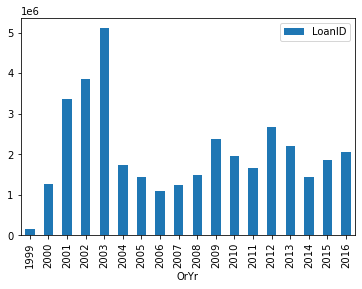

In [15]:
df_acq_summary.to_pandas().sort_values(by=['OrYr']).plot.bar(x='OrYr',y='LoanID')

<AxesSubplot:xlabel='OrYr'>

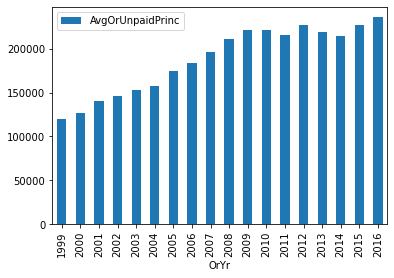

In [34]:
df_acq_summary.to_pandas().sort_values(by=['OrYr']).plot.bar(x='OrYr',y='AvgOrUnpaidPrinc')

https://stackoverflow.com/questions/49228596/pandas-case-when-default-in-pandas

In [11]:
df_per['YrRep']=df_per['MonthRep'].str[-4:]
df_per['CAUPB $M']=df_per['CAUPB']/1000000
df_per_summary = df_per.groupby('MonthRep',as_index=False).agg({'CAUPB $M': 'sum','LoanID': 'count'}).persist()
progress(df_per_summary)

VBox()

<AxesSubplot:xlabel='MonthRep'>

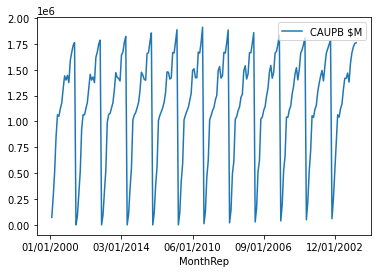

In [18]:
#df_per_summary=df_per_summary.compute()
df_per_summary['YrRep']=df_per_summary['MonthRep'].str[-4:]
df_per_summary.to_pandas().sort_values(by=['MonthRep']).plot.line(x='MonthRep',y='CAUPB $M')

In [10]:
zbcodes_summary = df_per.groupby('ZeroBalCode',as_index=False).agg({'LoanID': 'count'}).persist()
progress(zbcodes_summary)

VBox()

Unique Zero Balance Codes

In [11]:
zbcodes_summary.compute()

,ZeroBalCode,LoanID
0,<NA>,1863621801
1,9.0,427482
2,15.0,19682
3,1.0,26055117
4,2.0,46262
5,6.0,67953
6,3.0,104090
7,16.0,11293


In [12]:
clds_summary = df_per.groupby('CLDS',as_index=False).agg({'LoanID': 'count'}).persist()
progress(clds_summary)

VBox()

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [100]:
df_per.head(5)

,LoanID,MonthRep,CAUPB,CLDS,ForeclosureDate,DelinquentEvent,ForeclosureEvent
0,100007365142,01/01/2000,<NA>,0.0,<NA>,0.0,0
1,100007365142,01/01/2001,74319.0,0.0,<NA>,0.0,0
2,100007365142,01/01/2002,73635.48,0.0,<NA>,0.0,0
3,100007365142,01/01/2003,72795.41,0.0,<NA>,0.0,0
4,100007365142,02/01/2000,<NA>,0.0,<NA>,0.0,0


In [141]:
df_per['DelinquentEvent']=0
df_per['DelinquentEvent']=df_per['DelinquentEvent'].where(df_per['CLDS']<1,1)
df_per['ForeclosureEvent']=0
df_per['ForeclosureEvent']=df_per['ForeclosureEvent'].where(df_per['ForeclosureDate'].isnull()== True,1)


# df_per.assign(col1=df_per['ZeroBalCode'].where(cond))
#df_per.assign('Last_Status2'=lambda x: 'Active' if x['ZeroBalCode']==9 else 'Not Active')
# df_per['Last_Status1'] = df_per['ZeroBalCode'].apply(f)
#df_per['Last_Status2'] = df_per[df_per['CLDS']==8]

In [144]:
# is_delinquent= df_per['DelinquentEvent']==1
# df_per[is_delinquent].head(10)

df_per[df_per['CLDS']>0].head(10)
df_per[df_per['ForeclosureDate'].notnull()].head(10)

,LoanID,MonthRep,CAUPB,CLDS,ForeclosureDate,DelinquentEvent,ForeclosureEvent
6028,100557946796,12/01/2003,81768.36,-1.0,12/01/2003,0.0,1
6256,100579898395,08/01/2003,132690.80,-1.0,08/01/2003,0.0,1
7169,100687390672,12/01/2000,119591.99,-1.0,12/01/2000,0.0,1
7459,100710809124,03/01/2004,12979.31,-1.0,03/01/2004,0.0,1
25586,102577665265,02/01/2003,233103.85,-1.0,02/01/2003,0.0,1
26969,102735376578,06/01/2003,168905.01,-1.0,06/01/2003,0.0,1
38020,103968872789,05/01/2004,124391.16,-1.0,05/01/2004,0.0,1
38991,104143486346,03/01/2012,33304.30,-1.0,03/01/2012,0.0,1
39143,104144116732,11/01/2003,66727.36,-1.0,11/01/2003,0.0,1
45564,104928430484,12/01/2004,30710.53,-1.0,12/01/2004,0.0,1


In [110]:
df_per.dtypes

LoanID                int64
MonthRep             object
CAUPB               float64
CLDS                float64
ForeclosureDate      object
DelinquentEvent     float64
ForeclosureEvent      int64
dtype: object

In [85]:
df_per[['ZeroBalCode', 'Last_Status1','Last_Status2']].tail()

KeyError: 'ZeroBalCode'

In [36]:
df_per['Last_Status1'].head()

0    Not Active
1    Not Active
2    Not Active
3    Not Active
4    Not Active
Name: Last_Status1, dtype: object

In [25]:
df_per['ZeroBalCode'].head()

0    <NA>
1    <NA>
2    <NA>
3    <NA>
4    <NA>
Name: ZeroBalCode, dtype: float64

In [26]:
ddf1.col1.head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: col1, dtype: float64

In [10]:
df_per_summary = df_per.groupby('MonthRep',as_index=False).agg({'CAUPB $M': 'sum','LoanID': 'count'}).persist()
progress(df_per_summary)

KeyError: 'CAUPB $M'

In [ ]:
del df_per_summary2

In [ ]:
df_per_summary.head()

In [ ]:
%time df_per_csv = dask_cudf.read_csv(csv_perf_fnames, sep='|', names=col_per_names, dtype=dtype_per, parse_dates=parse_dates_per)
df_per_summary = df_per_csv.groupby('MonthRep',as_index=False).agg({'CAUPB': 'sum','LoanID': 'count'}).persist()
progress(df_per_summary)

In [ ]:
df_per_summary=df_per_summary.compute()

In [ ]:
# test=df_per_summary.to_pandas().reset_index()
#test
#test['MonthRep']=pd.to_datetime(test['MonthRep'])
# test.sort_values(by=['MonthRep'])
# test.sort_values(by=['MonthRep']).plot.line(x='MonthRep', y='CAUPB')
df_per_summary.to_pandas().plot.line(x='MonthRep', y='CAUPB')

In [ ]:
df_per_latest=df_per.drop_duplicates(subset='LoanID', keep='last', inplace=False).persist()
progress(df_per_latest)

In [ ]:
df_acq=df_acq.compute()
df_per_latest=df_per_latest.compute()
print(df_per_latest.shape)
print(df_acq.shape)

In [ ]:
#joined=df_acq.merge(df_per_latest,on=['LoanID'],how='left')
joined['OrYr']=joined['OrDate'].str[-4:]
joined['CAUPB $M']=joined['CAUPB']/1000000
joined['OrUnpaidPrinc $M']=joined['OrUnpaidPrinc']/1000000
#joined['Active']=np.where(joined['MonthsToMaturity']>0,'Active','Not Active')
joined['Active']='Active'
joined['Active'].where(joined['MonthsToMaturity']>0,'Not Active')

In [ ]:
joined[joined['Active']=='Active']

In [ ]:
joined_summary = joined.groupby('OrYr').agg({'OrUnpaidPrinc $M': 'sum','LoanID': 'count'})
# df_per_latest_summary.compute().to_pandas().sort_values(by=['MonthRep'])

In [ ]:
active loands by year-month

In [ ]:
joined_summary.to_pandas().plot.line()

In [ ]:
#del df_per_latest
del df_acq

In [ ]:
joined[joined['OrYr']=='1999']

In [ ]:
joined_summary[]

In [ ]:
by year-month: # of defaults / active loands = default rates

## Appendix